In [1]:
import s3fs
import h5py
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import requests
import boto3
import s3fs
from os.path import dirname, join
from pprint import pprint
from pyresample import kd_tree, geometry, utils
from pyresample.geometry import GridDefinition
from pathlib import Path
import os
import time
import random
from datetime import date
from os.path import exists

In [2]:
fig_dir = Path('/home/jovyan/Figures/ECCO_GMSL/')

### Confirm Existence of .netrc file in your home directory

In [3]:
!cat ~/.netrc | grep 'urs.earthdata.nasa.gov' | wc -l

1


### Get credentials

In [4]:
%%capture
import requests

def store_aws_keys(endpoint: str="https://archive.podaac.earthdata.nasa.gov/s3credentials"):    
    with requests.get(endpoint, "w") as r:
        accessKeyId, secretAccessKey, sessionToken, expiration = list(r.json().values())

    creds ={}
    creds['AccessKeyId'] = accessKeyId
    creds['SecretAccessKey'] = secretAccessKey
    creds['SessionToken'] = sessionToken
    creds['expiration'] = expiration
    
    return creds

creds = store_aws_keys()
print(creds)

In [5]:
print(f"\nThe current session token expires at {creds['expiration']}.\n")


The current session token expires at 2023-08-08 00:10:12+00:00.



# Define important params

In [6]:
# ECCO Starts on Jan 1, 1992
ECCO_start_time= np.datetime64('1992-09-23')
mean_file_dir = Path('/home/jovyan/Data/ECCO_GMSL/')
alongtrack_file_dir = Path('/home/jovyan/Data/ECCO_GMSL/errors/orbiterror_missingdata_3cm')

# SIC dir
sic_dir=Path('/home/jovyan/Data/ECCO_GMSL/SIC_ECCO_DAILY_V4R4B/')

# output directory
output_dir_noerror=Path('/home/jovyan/Data/ECCO_GMSL/ECCO_V4r4_alongtrack_output')
output_dir_missingdata=Path('/home/jovyan/Data/ECCO_GMSL/ECCO_V4r4_alongtrack_output_missingdata')
output_dir=Path('/home/jovyan/Data/ECCO_GMSL/ECCO_V4r4_alongtrack_output_3errors_3cm')
output_dir.mkdir(exist_ok=True)

strerror='3 cm'

# Prepare ECCO Daily SSH dataset

In [6]:
ShortName = "ECCO_L4_SSH_05DEG_DAILY_V4R4B"

# Load the ECCO spatial mean 1992-2017

In [7]:
ecco_mean = xr.open_dataset(str(mean_file_dir) + '/ECCO_V4r4_mean_SSH.nc')
ecco_mean

<xarray.Dataset>
Dimensions:    (latitude: 360, longitude: 720)
Coordinates:
  * latitude   (latitude) float32 -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * longitude  (longitude) float32 -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
Data variables:
    mean_ssh   (latitude, longitude) float32 ...

In [8]:
# Ask PODAAC for the collection id
response = requests.get(
    url='https://cmr.earthdata.nasa.gov/search/collections.umm_json', 
    params={'provider': "POCLOUD",
            'ShortName': ShortName,
            'page_size': 1}
)

# ummc = response.json()['items'][0]
# ccid = ummc['meta']['concept-id']
# print(f'collection id: {ccid}')

## Make a "direct connection" to the S3 file system

In [9]:
s3 = s3fs.S3FileSystem(
    key=creds['AccessKeyId'],
    secret=creds['SecretAccessKey'],
    token=creds['SessionToken'],
    client_kwargs={'region_name':'us-west-2'},
)

In [10]:
# make a S3 'filesystem' object
fs = s3fs.S3FileSystem(anon=False,
                      key=creds['AccessKeyId'],
                      secret=creds['SecretAccessKey'],
                      token=creds['SessionToken'])

## Load all of the files for this year from AWS S3 using 'direct connection' and combine into a single xarray DataSet object

### Test

In [11]:
year=1993

ECCO_SSH_files = fs.glob(join("podaac-ops-cumulus-protected/", ShortName, '*'+ str(year) + '*.nc'))
paths=[fs.open(f) for f in ECCO_SSH_files]

ECCO_DS_daily = xr.open_mfdataset(
    paths=paths,
    combine='nested',
    concat_dim='time',
    decode_cf=True,
    coords='minimal',
    chunks={'time': 1}  
    )
ECCO_DS_daily.close()

# Load SIC files
ECCO_SIC_files = list(sic_dir.glob('*'+ str(year) + '*.nc'))
ECCO_SIC_files=np.sort(ECCO_SIC_files)
ECCO_SIC_daily = xr.open_mfdataset(
    paths=ECCO_SIC_files,
    combine='nested',
    concat_dim='time',
    compat='override',
    decode_cf=True,
    coords='minimal',
    chunks={'time': 1}  
)
ECCO_DS_daily=ECCO_DS_daily.where(ECCO_SIC_daily.SIarea <= 0) #change to NaN everything that is False

ECCO_SSH = ECCO_DS_daily.SSH-ecco_mean.mean_ssh
ECCO_lons, ECCO_lats = np.meshgrid(ECCO_SSH.longitude, ECCO_SSH.latitude)
ECCO_grid_def = GridDefinition(lons=ECCO_lons, lats=ECCO_lats)

f=0
# get the date/time associated with this record
rec_time = ECCO_SSH.time.dt.floor("D")[f]

# Count how many days since ecco start time?
delta_days = int((rec_time.values - ECCO_start_time)/1e9/86400)

# Determine which GSFC cycle it is 
cycle = int(np.floor(delta_days / 10)+1)
print('cycle: '+str(cycle))

# Determine which cycle day we're in: cycle day is delta_days mod 10
cycle_day = delta_days % 10

cycle: 11


In [12]:
# Load the corresponding orbit error data file
filename=str(alongtrack_file_dir) + '/AlongTrack_sample_'+str(cycle).zfill(4)+'_orbiterror_missingdata.nc'
alongtrack = xr.open_dataset(filename, decode_times=False)
alongtrack

<xarray.Dataset>
Dimensions:      (i: 602812)
Coordinates:
  * i            (i) int64 0 1 2 3 4 5 ... 602807 602808 602809 602810 602811
Data variables:
    time         (i) int64 ...
    y            (i) float32 ...
    x            (i) float32 ...
    orbit_nb     (i) int16 ...
    orbit_error  (i) float64 ...

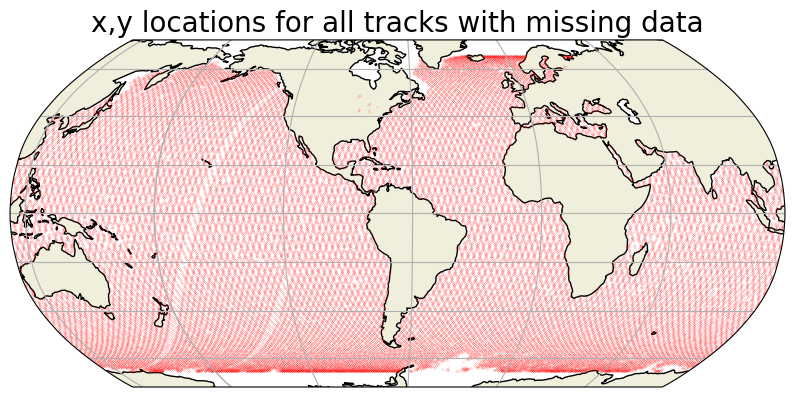

In [13]:
plt.close()
fig = plt.figure(figsize=(10,5))
ax = plt.axes(projection=ccrs.Robinson( \
              central_longitude=-67, globe=None))
ax.gridlines()
ax.add_feature(cfeature.LAND)
#ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)

kk=10
p=ax.plot(alongtrack.x[::kk],
          alongtrack.y[::kk], 'r.', markersize=0.2,\
          transform=ccrs.PlateCarree())

# plot x,y locations with nan time
ins = np.where(np.isnan(alongtrack.time.values))[0]
p=ax.plot(alongtrack.x.values[ins[::10]],
          alongtrack.y.values[ins[::10]], 'b.', markersize=5,\
          transform=ccrs.PlateCarree())

plt.title('x,y locations for all tracks with missing data', fontsize=20)
plt.show()

In [14]:
#Create a dictionary with x,y points for each of the 10 cycle days on the alongtrack sample file
x_track_in_d = {}
y_track_in_d = {}

alongtrack_swath = {}
orbiterror_in_d = {}
tc = 0
all_ins = []
d_total = 0
for d in range(10):
    d_start = d*86400
    d_end = d_start + 86400
    ins = np.where(np.logical_and.reduce((alongtrack.time.values >= d_start, alongtrack.time.values < d_end, np.isfinite(alongtrack.y.values))))[0]
    print(f'cycle day: {d}, time_start {d_start}s, time_end {d_end}s, number of xy points {len(ins)}')    

    ins = np.where(np.logical_and.reduce((alongtrack.time.values >= d_start, alongtrack.time.values < d_end)))[0]
    if len(ins)>0:
        orbiterror_in_d[d]=alongtrack.orbit_error[ins] 

        all_ins.append(ins) 
        x_track_in_d[d],y_track_in_d[d] = utils.check_and_wrap(alongtrack.x[ins],  alongtrack.y[ins])

        tc = tc + len(ins)
        # this handy pyresample object will allow us to map from the gridded ECCO fields to the alongtrack points
        alongtrack_swath[d] =  geometry.SwathDefinition(lons=x_track_in_d[d], lats=y_track_in_d[d])

cycle day: 0, time_start 0s, time_end 86400s, number of xy points 53522
cycle day: 1, time_start 86400s, time_end 172800s, number of xy points 55076
cycle day: 2, time_start 172800s, time_end 259200s, number of xy points 55226
cycle day: 3, time_start 259200s, time_end 345600s, number of xy points 53999
cycle day: 4, time_start 345600s, time_end 432000s, number of xy points 52386
cycle day: 5, time_start 432000s, time_end 518400s, number of xy points 54757
cycle day: 6, time_start 518400s, time_end 604800s, number of xy points 53870
cycle day: 7, time_start 604800s, time_end 691200s, number of xy points 54200
cycle day: 8, time_start 691200s, time_end 777600s, number of xy points 53379
cycle day: 9, time_start 777600s, time_end 864000s, number of xy points 51772


In [15]:
cycle_day=2 #cycle days 0 and 1 have no data
# sample the ECCO field at the x,y locations for this cycle day 
# search within a 200 km radius for the nearest neighbor.
# (overkill since it's a 1 degree model but just to be safe)
ECCO_at_xy_points =\
    kd_tree.resample_nearest(ECCO_grid_def, \
                             ECCO_SSH[f].values, \
                             alongtrack_swath[cycle_day],\
                             radius_of_influence=200000, fill_value = np.nan)

#add random noise to the alongtrack array, mu=0, std=3cm (0.03m)
ECCO_at_xy_points = ECCO_at_xy_points+np.random.normal(0,0.03,len(ECCO_at_xy_points))
        
# make a new DataArray object
ECCO_at_xy_points_da = xr.DataArray(ECCO_at_xy_points+orbiterror_in_d[cycle_day], dims=['i'])
ECCO_at_xy_points_da = ECCO_at_xy_points_da.assign_coords({'time':rec_time})
ECCO_at_xy_points_da = ECCO_at_xy_points_da.assign_coords({'cycle_day':cycle_day})
ECCO_at_xy_points_da = ECCO_at_xy_points_da.assign_coords({'cycle':cycle})
ECCO_at_xy_points_da = ECCO_at_xy_points_da.assign_coords({'delta_days':delta_days})
ECCO_at_xy_points_da = ECCO_at_xy_points_da.assign_coords({'lon':('i', x_track_in_d[cycle_day].values)})
ECCO_at_xy_points_da = ECCO_at_xy_points_da.assign_coords({'lat':('i', y_track_in_d[cycle_day].values)})
ECCO_at_xy_points_da.delta_days.attrs['comment'] = 'days since '+str(ECCO_start_time)
ECCO_at_xy_points_da.cycle_day.attrs['comment'] = 'which day in 10 day cycle'
ECCO_at_xy_points_da.cycle.attrs['comment'] = 'Total cycle since '+str(ECCO_start_time)

ECCO_at_xy_points_da.name = 'SSH_at_xy'
ECCO_at_xy_points_da.attrs['source']='ECCO V4r4'
ECCO_at_xy_points_da   

<xarray.DataArray 'SSH_at_xy' (i: 61022)>
array([nan, nan, nan, ..., nan, nan, nan])
Coordinates:
  * i           (i) int64 120074 120075 120076 120077 ... 181093 181094 181095
    time        datetime64[ns] 1993-01-01
    cycle_day   int64 2
    cycle       int64 11
    delta_days  int64 100
    lon         (i) float32 nan nan nan -63.59 -63.56 ... nan nan nan nan nan
    lat         (i) float32 nan nan nan -41.41 -41.46 ... nan nan nan nan nan
Attributes:
    unit:       cm
    long_name:  orbit error = amplitude * sin(2 pi t/T + phase)
    source:     ECCO V4r4

Text(0.5, 1.0, 'orbit error 3 cm')

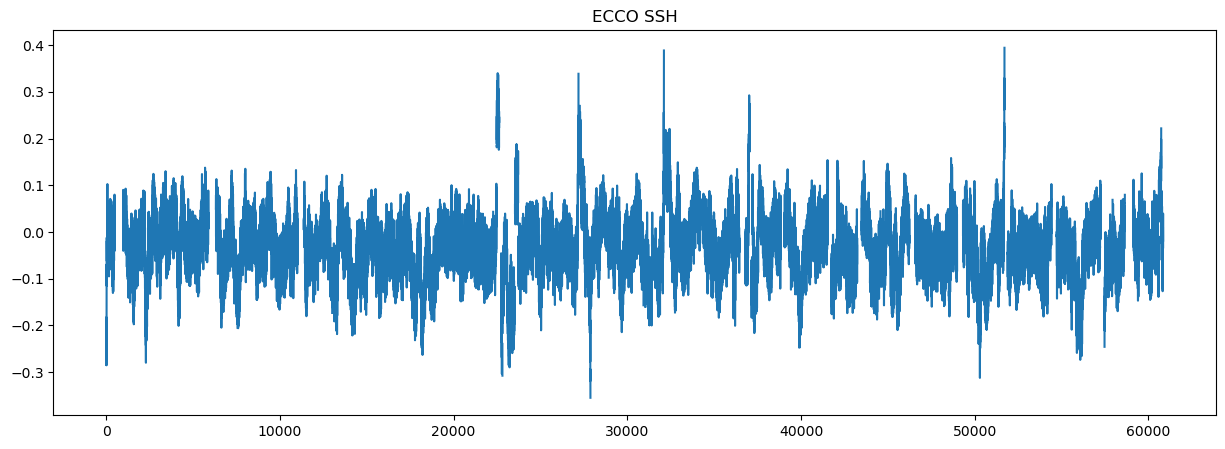

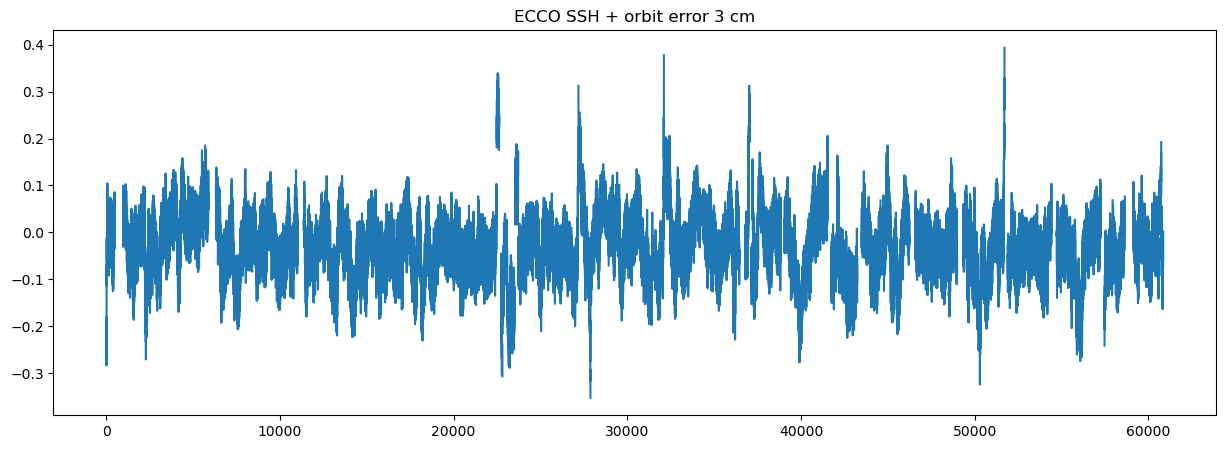

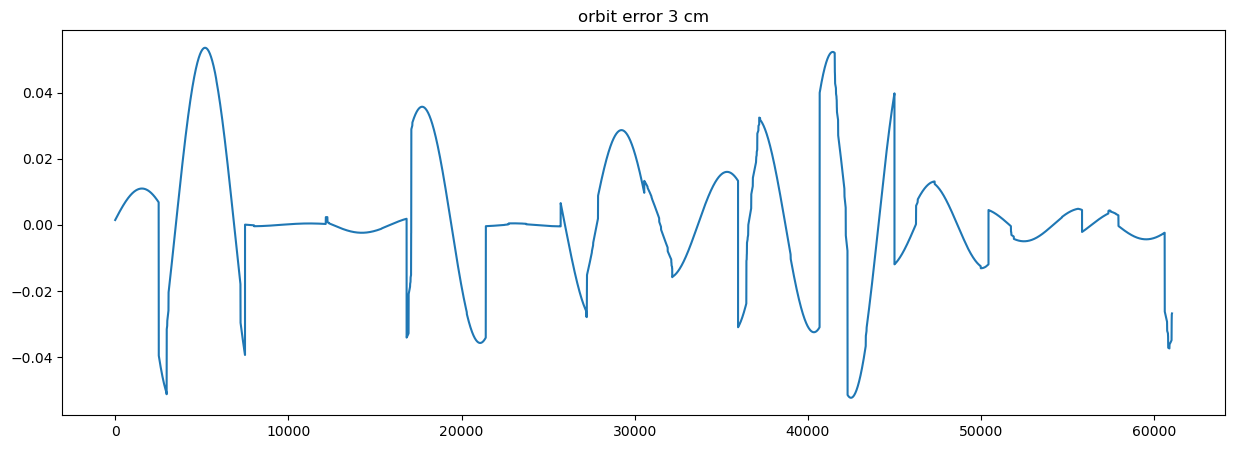

In [16]:
fig = plt.figure(figsize=(15,5))
plt.plot(ECCO_at_xy_points)
plt.title('ECCO SSH')

fig = plt.figure(figsize=(15,5))
plt.plot(ECCO_at_xy_points+orbiterror_in_d[cycle_day])
plt.title('ECCO SSH + orbit error '+strerror)

fig = plt.figure(figsize=(15,5))
plt.plot(orbiterror_in_d[cycle_day])
plt.title('orbit error '+strerror)

### All Time Series

In [17]:
for year in range(1992,2018): #1992,2018
    
    start_time = time.time()
    ECCO_SSH_files = fs.glob(join("podaac-ops-cumulus-protected/", ShortName, '*'+ str(year) + '*.nc'))
    paths=[fs.open(f) for f in ECCO_SSH_files]
    
    ECCO_DS_daily = xr.open_mfdataset(
    paths=paths,
    combine='nested',
    concat_dim='time',
    decode_cf=True,
    coords='minimal',
    chunks={'time': 1}  
    )
    ECCO_DS_daily.close()

    # Load SIC files
    ECCO_SIC_files = list(sic_dir.glob('*'+ str(year) + '*.nc'))
    ECCO_SIC_files=np.sort(ECCO_SIC_files)
    ECCO_SIC_daily = xr.open_mfdataset(
        paths=ECCO_SIC_files,
        combine='nested',
        concat_dim='time',
        compat='override',
        decode_cf=True,
        coords='minimal',
        chunks={'time': 1}  
    )
    ECCO_DS_daily=ECCO_DS_daily.where(ECCO_SIC_daily.SIarea <= 0) #change to NaN everything that is False

    ECCO_SSH = ECCO_DS_daily.SSH-ecco_mean.mean_ssh
    ECCO_lons, ECCO_lats = np.meshgrid(ECCO_SSH.longitude, ECCO_SSH.latitude)
    ECCO_grid_def = GridDefinition(lons=ECCO_lons, lats=ECCO_lats)
    
    # Loop through all days
    for f in range(len(ECCO_SSH.time)):
        # get the date/time associated with this record
        rec_time = ECCO_SSH.time.dt.floor("D")[f]

        # Count how many days since ecco start time?
        delta_days = int((rec_time.values - ECCO_start_time)/1e9/86400)
        if delta_days>=0:

            # Determine which GSFC cycle it is 
            cycle = int(np.floor(delta_days / 10)+1)
            # print(cycle)

            # Determine which cycle day we're in: cycle day is delta_days mod 10
            cycle_day = delta_days % 10

            # Load the corresponding orbit error and missing data data file
            filename=str(alongtrack_file_dir) + '/AlongTrack_sample_'+str(cycle).zfill(4)+'_orbiterror_missingdata.nc'
            if exists(filename):
                alongtrack = xr.open_dataset(filename, decode_times=False)

                #Create a dictionary with x,y points for each of the 10 cycle days on the alongtrack sample file with orbit error    
                x_track_in_d = {}
                y_track_in_d = {}
                alongtrack_swath = {}
                orbiterror_in_d = {}
                tc = 0
                all_ins = []
                for d in range(10):
                    d_start = d*86400
                    d_end = d_start + 86400
                    ins = np.where(np.logical_and(alongtrack.time >= d_start, alongtrack.time < d_end))[0]

                    if len(ins)>0:
                        all_ins.append(ins) 
                        x_track_in_d[d],y_track_in_d[d] = utils.check_and_wrap(alongtrack.x[ins],  alongtrack.y[ins])
                        orbiterror_in_d[d] = alongtrack.orbit_error[ins]

                        # print(f'cycle day: {d}, time_start {d_start}s, time_end {d_end}s, number of xy points {len(ins)}')

                        tc = tc + len(ins)
                        # this handy pyresample object will allow us to map from the gridded ECCO fields to the alongtrack points
                        alongtrack_swath[d] =  geometry.SwathDefinition(lons=x_track_in_d[d], lats=y_track_in_d[d])

                # sample the ECCO field at the x,y locations for this cycle day 
                # search within a 200 km radius for the nearest neighbor.
                # (overkill since it's a 1 degree model but just to be safe)
                try:
                    ECCO_at_xy_points =\
                        kd_tree.resample_nearest(ECCO_grid_def, \
                                                 ECCO_SSH[f].values, \
                                                 alongtrack_swath[cycle_day],\
                                                 radius_of_influence=200000, fill_value = np.nan)

                    #add random noise to the alongtrack array, mu=0, std=3cm (0.03m)
                    ECCO_at_xy_points = ECCO_at_xy_points+np.random.normal(0,0.03,len(ECCO_at_xy_points))

                    # make a new DataArray object
                    ECCO_at_xy_points_da = xr.DataArray(ECCO_at_xy_points+orbiterror_in_d[cycle_day], dims=['i'])
                    ECCO_at_xy_points_da = ECCO_at_xy_points_da.assign_coords({'time':rec_time})
                    ECCO_at_xy_points_da = ECCO_at_xy_points_da.assign_coords({'cycle_day':cycle_day})
                    ECCO_at_xy_points_da = ECCO_at_xy_points_da.assign_coords({'cycle':cycle})
                    ECCO_at_xy_points_da = ECCO_at_xy_points_da.assign_coords({'delta_days':delta_days})
                    ECCO_at_xy_points_da = ECCO_at_xy_points_da.assign_coords({'lon':('i', x_track_in_d[cycle_day].values)})
                    ECCO_at_xy_points_da = ECCO_at_xy_points_da.assign_coords({'lat':('i', y_track_in_d[cycle_day].values)})
                    ECCO_at_xy_points_da.delta_days.attrs['comment'] = 'days since '+str(ECCO_start_time)
                    ECCO_at_xy_points_da.cycle_day.attrs['comment'] = 'which day in 10 day cycle'
                    ECCO_at_xy_points_da.cycle.attrs['comment'] = 'Total cycle since '+str(ECCO_start_time)

                    ECCO_at_xy_points_da.name = 'SSH_at_xy'
                    ECCO_at_xy_points_da.attrs['source']='ECCO V4r4'
                    ECCO_at_xy_points_da   

                    # Save to Disk
                    new_fname = 'ECCO_V4r4_alongtrack_SSH_' + str(rec_time.values).split('T')[0] + '_3errors.nc'
                    ECCO_at_xy_points_da.to_netcdf(output_dir / new_fname)
                except:
                    print('no data for '+str(rec_time.values).split('T')[0])
    
    print(year, time.time() - start_time, cycle)

2006 232.8794195652008 522
2007 253.86568021774292 558
2008 253.9878854751587 595
2009 248.66889071464539 631
2010 250.43136644363403 668
2011 246.06982231140137 704
2012 251.82690286636353 741
2013 252.92476415634155 777
2014 258.7426338195801 814
2015 258.5682921409607 850
2016 260.96101427078247 887
2017 261.9206953048706 924


# Plot 10 days of along track SSH

In [7]:
year=1992
ECCO_alongtrack_files = np.sort(list(output_dir.glob('*ECCO_V4r4_alongtrack_SSH_'+str(year)+'*nc')))
ECCO_alongtrack_files_noerror = np.sort(list(output_dir_missingdata.glob('*ECCO_V4r4_alongtrack_SSH_'+str(year)+'*nc')))

In [8]:
tmp = []
tmp2 = []
# any 10 sequential days comprises one full cycle
for d in range(0,10):
    try:
        tmp.append(xr.open_dataset(ECCO_alongtrack_files[d]))
        tmp2.append(xr.open_dataset(ECCO_alongtrack_files_noerror[d]))
        print(ECCO_alongtrack_files[d])
        print(ECCO_alongtrack_files_noerror[d])
    except:
        print('missing days in cycle')

/home/jovyan/Data/ECCO_GMSL/ECCO_V4r4_alongtrack_output_3errors_3cm/ECCO_V4r4_alongtrack_SSH_1992-09-23_3errors.nc
/home/jovyan/Data/ECCO_GMSL/ECCO_V4r4_alongtrack_output_missingdata/ECCO_V4r4_alongtrack_SSH_1992-09-23_missingdata.nc
/home/jovyan/Data/ECCO_GMSL/ECCO_V4r4_alongtrack_output_3errors_3cm/ECCO_V4r4_alongtrack_SSH_1992-09-24_3errors.nc
/home/jovyan/Data/ECCO_GMSL/ECCO_V4r4_alongtrack_output_missingdata/ECCO_V4r4_alongtrack_SSH_1992-09-24_missingdata.nc
/home/jovyan/Data/ECCO_GMSL/ECCO_V4r4_alongtrack_output_3errors_3cm/ECCO_V4r4_alongtrack_SSH_1992-09-25_3errors.nc
/home/jovyan/Data/ECCO_GMSL/ECCO_V4r4_alongtrack_output_missingdata/ECCO_V4r4_alongtrack_SSH_1992-09-25_missingdata.nc
/home/jovyan/Data/ECCO_GMSL/ECCO_V4r4_alongtrack_output_3errors_3cm/ECCO_V4r4_alongtrack_SSH_1992-09-26_3errors.nc
/home/jovyan/Data/ECCO_GMSL/ECCO_V4r4_alongtrack_output_missingdata/ECCO_V4r4_alongtrack_SSH_1992-09-26_missingdata.nc
/home/jovyan/Data/ECCO_GMSL/ECCO_V4r4_alongtrack_output_3errors_

adding cycle day 0
adding cycle day 1
adding cycle day 2
adding cycle day 3
adding cycle day 4
adding cycle day 5
adding cycle day 6
adding cycle day 7
adding cycle day 8
adding cycle day 9


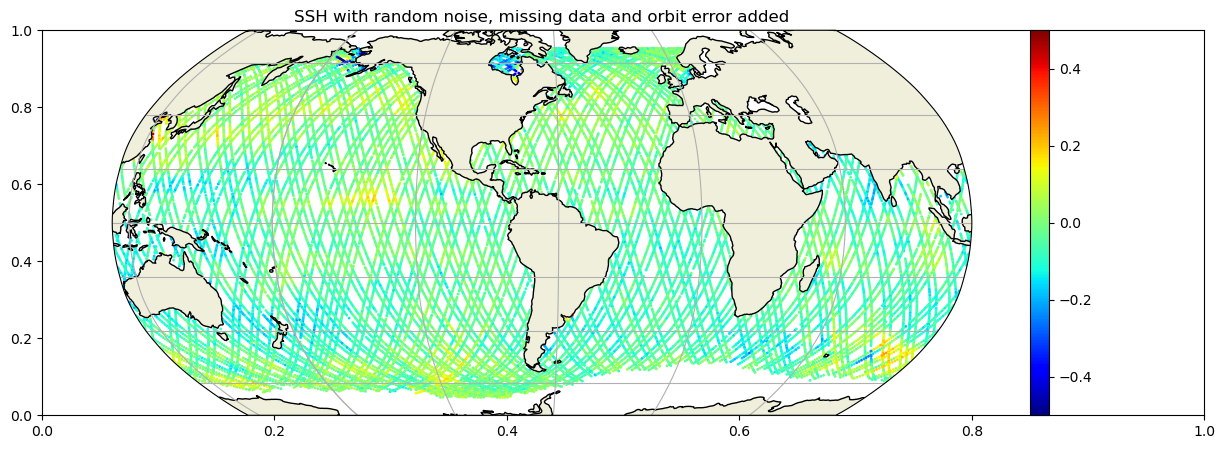

In [9]:
fig = plt.figure(figsize=(15,5))
cm = plt.get_cmap('gist_rainbow')
ax=fig.gca()

ax = plt.axes(projection=ccrs.Robinson( \
              central_longitude=-67, globe=None))
ax.gridlines()
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)

kk=12

for d in range(10):
    try:
        ECCO_at_xy = tmp[d].SSH_at_xy
        print(f'adding cycle day {ECCO_at_xy.cycle_day.values}')

        p=ax.scatter(ECCO_at_xy.lon[::kk],\
                     ECCO_at_xy.lat[::kk], \
                     c=ECCO_at_xy[::kk], s=1,\
                     transform=ccrs.PlateCarree(),
                     vmin=-0.5,vmax=0.5, cmap='jet')
        ax.set_title('SSH with random noise, missing data and orbit error added')
    except:
        print('missing days in cycle')
plt.colorbar(p)

adding cycle day 0
adding cycle day 1
adding cycle day 2
adding cycle day 3
adding cycle day 4
adding cycle day 5
adding cycle day 6
adding cycle day 7
adding cycle day 8
adding cycle day 9


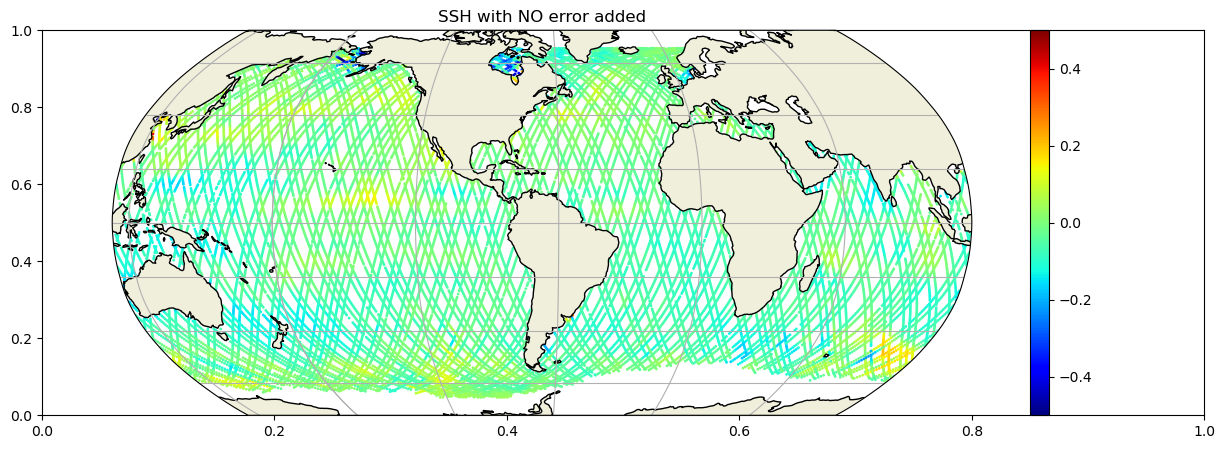

In [10]:
fig = plt.figure(figsize=(15,5))
cm = plt.get_cmap('gist_rainbow')
ax=fig.gca()

ax = plt.axes(projection=ccrs.Robinson( \
              central_longitude=-67, globe=None))
ax.gridlines()
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)

kk=12
for d in range(10):
    try:
        ECCO_at_xy = tmp2[d].SSH_at_xy
        print(f'adding cycle day {ECCO_at_xy.cycle_day.values}')

        p=ax.scatter(ECCO_at_xy.lon[::kk],\
                     ECCO_at_xy.lat[::kk], \
                     c=ECCO_at_xy[::kk], s=1,\
                     transform=ccrs.PlateCarree(),
                     vmin=-0.5,vmax=0.5, cmap='jet')
        ax.set_title('SSH with NO error added')
    except:
        print('missing days in cycle')
plt.colorbar(p)

adding cycle day 0
missing days in cycle
adding cycle day 1
missing days in cycle
adding cycle day 2
missing days in cycle
adding cycle day 3
missing days in cycle
adding cycle day 4
missing days in cycle
adding cycle day 5
missing days in cycle
adding cycle day 6
missing days in cycle
adding cycle day 7
missing days in cycle
adding cycle day 8
missing days in cycle
adding cycle day 9
missing days in cycle


/tmp/ipykernel_1724/718228012.py:64: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(16)
/tmp/ipykernel_1724/718228012.py:66: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(16)


adding cycle day 0
adding cycle day 1
adding cycle day 2
adding cycle day 3
adding cycle day 4
adding cycle day 5
adding cycle day 6
adding cycle day 7
adding cycle day 8
adding cycle day 9


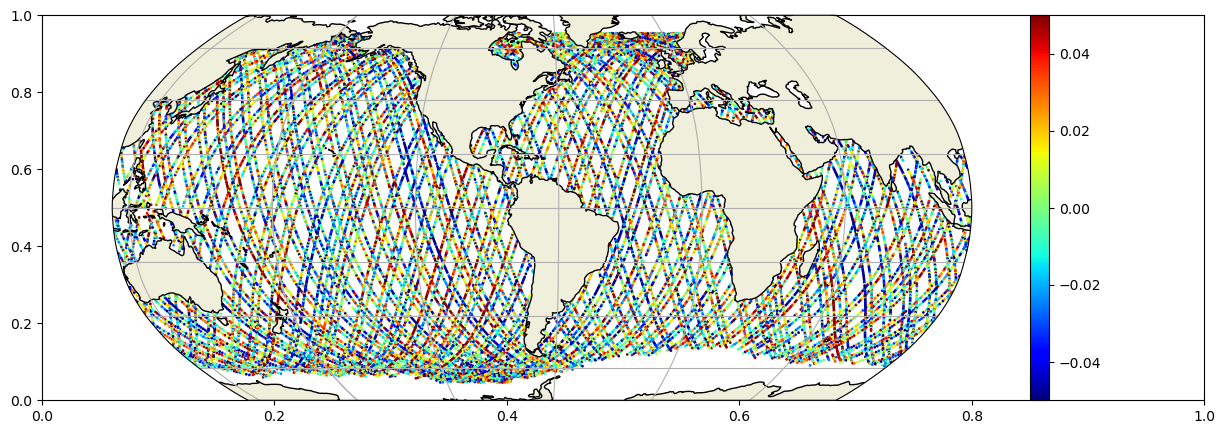

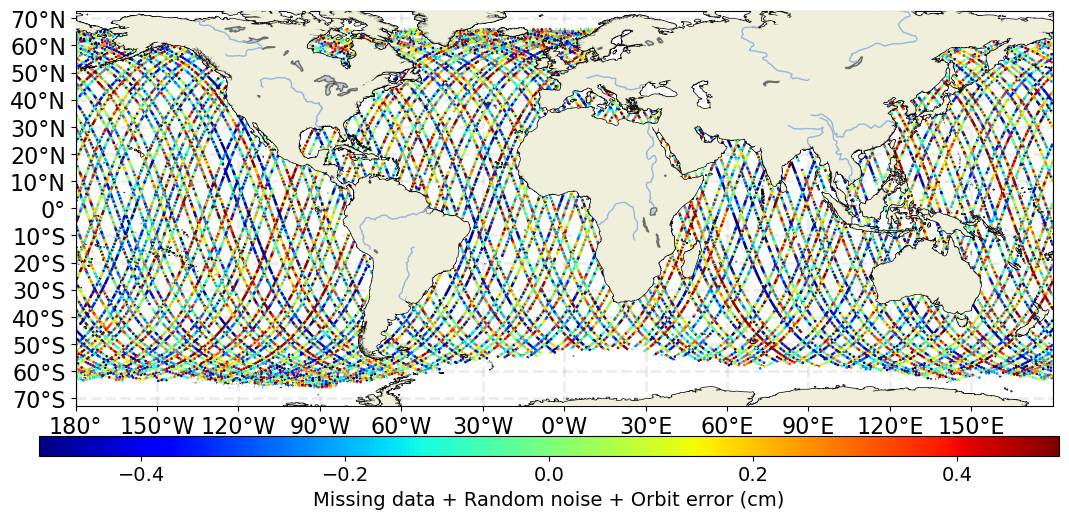

In [15]:
fig = plt.figure(figsize=(15,5))
cm = plt.get_cmap('gist_rainbow')
ax=fig.gca()

ax = plt.axes(projection=ccrs.Robinson( \
              central_longitude=-67, globe=None))
ax.gridlines()
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)

kk=12

for d in range(10):
    try:
        ECCO_at_xy2 = tmp2[d].SSH_at_xy
        ECCO_at_xy = tmp[d].SSH_at_xy
        print(f'adding cycle day {ECCO_at_xy.cycle_day.values}')

        p=ax.scatter(ECCO_at_xy.lon[::kk],\
                     ECCO_at_xy.lat[::kk], \
                     c=ECCO_at_xy[::kk]-ECCO_at_xy2[::kk], s=1,\
                     transform=ccrs.PlateCarree(),
                     vmin=-0.05,vmax=0.05, cmap='jet')
        ax.set_title('SSH with 3 errors (orbit '+str(orbiterror)+') added-SSH with NO error added')
    except:
        print('missing days in cycle')
plt.colorbar(p)

lonmin = -180
lonmax = 180
latmin = -90
latmax = 90
box = [lonmin, lonmax, latmin, latmax]
latstep = 10
lonstep=30
land=True

import cartopy

def init_cartopy_global(projection, box, latstep, lonstep, land, zorder=4,**karg):
    import matplotlib.pyplot as plt
    import numpy
    import cartopy
    import matplotlib.ticker as mticker
    from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
    import cartopy.feature as cfeature

    # ax = plt.axes(projection=projection)
    ax=plt.subplot(1,1,1,projection=projection)
    if land==True:
        land_10m = cfeature.NaturalEarthFeature('physical', 'land', '10m',facecolor=cfeature.COLORS['land'])
        ax.add_feature(land_10m, zorder=zorder)
    ax.add_feature(cartopy.feature.LAKES, alpha=0.5, zorder=zorder,edgecolor='black')
    ax.add_feature(cartopy.feature.RIVERS, zorder=zorder)
    ax.coastlines('10m')
    # ax.stock_img()
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.set_xticks(numpy.arange(numpy.floor(box[0]),numpy.floor(box[1]),lonstep), crs=projection)
    ax.set_yticks(numpy.arange(numpy.floor(box[2]),numpy.floor(box[3]),latstep), crs=projection)
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(16)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(16)
    gl = ax.gridlines(draw_labels=False, linestyle='--', linewidth=2, alpha=0.15, color='gray')
    if 'pacific' in karg:
        gl.xlocator = mticker.FixedLocator(numpy.arange(box[1],box[0]+360,lonstep))
    else:
        gl.xlocator = mticker.FixedLocator(numpy.arange(numpy.floor(box[0]),numpy.floor(box[1])+lonstep,lonstep))
    gl.ylocator = mticker.FixedLocator(numpy.arange(numpy.floor(box[2]),numpy.floor(box[3])+latstep,latstep))
    return ax, gl


kk=12

fig = plt.figure(figsize=(15,5))
data_proj = cartopy.crs.PlateCarree(central_longitude=0)
map_proj = cartopy.crs.PlateCarree(central_longitude=0)
ax, gl = init_cartopy_global(map_proj, box, latstep, lonstep, land) 
palette=plt.cm.jet
palette.set_bad('w',1.0)
for d in range(10):
    ECCO_at_xy2 = tmp2[d].SSH_at_xy
    ECCO_at_xy = tmp[d].SSH_at_xy
    print(f'adding cycle day {ECCO_at_xy.cycle_day.values}')
    pp = plt.scatter(ECCO_at_xy.lon[::kk],ECCO_at_xy.lat[::kk],c=(ECCO_at_xy[::kk]-ECCO_at_xy2[::kk])*100, s=1,cmap=palette,vmin=-0.5,vmax=0.5,transform=data_proj) 
plt.subplots_adjust(right=0.9,left=0.1,top=0.99,bottom=0.2)
cbar_ax = fig.add_axes([0.15, 0.1, 0.68, 0.04])
h=plt.colorbar(pp, cax=cbar_ax,orientation='horizontal')
h.set_label('Missing data + Random noise + Orbit error (cm)',fontsize=14)
h.ax.tick_params(labelsize=14)
plt.savefig(fig_dir / 'map_cycle1_3errors.png',dpi=200,transparent=False,facecolor='white')

Text(0.5, 1.0, 'ECCO SSH - diff error-no error')

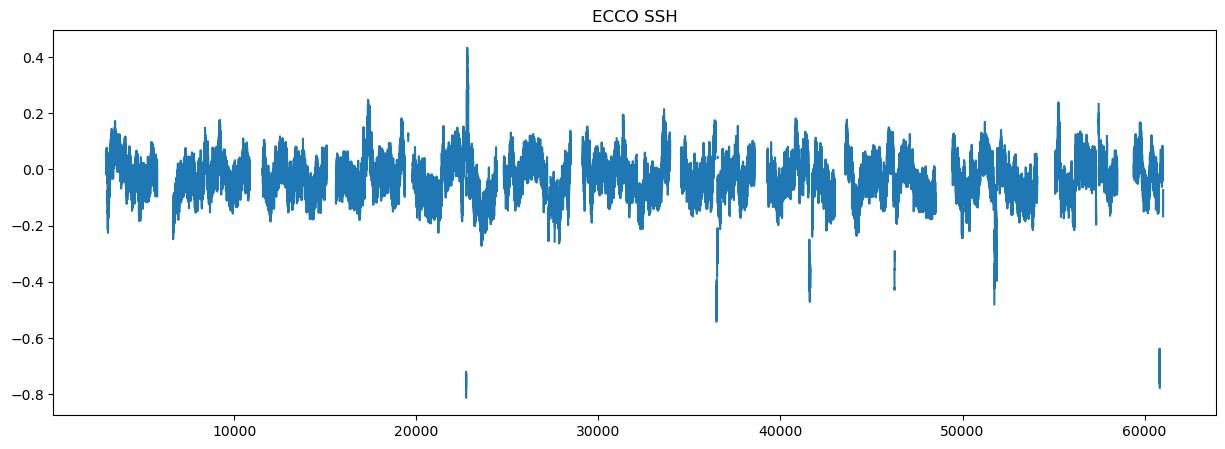

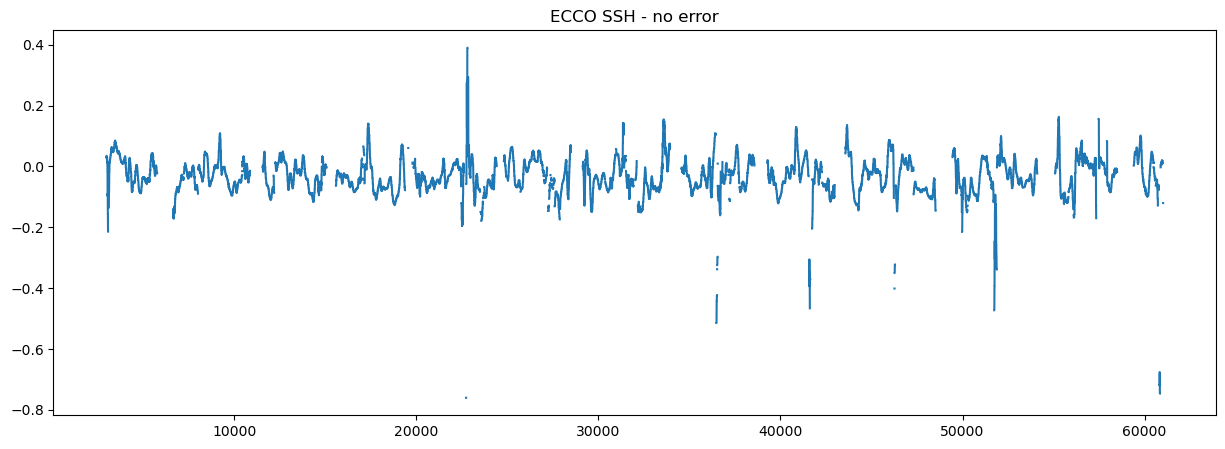

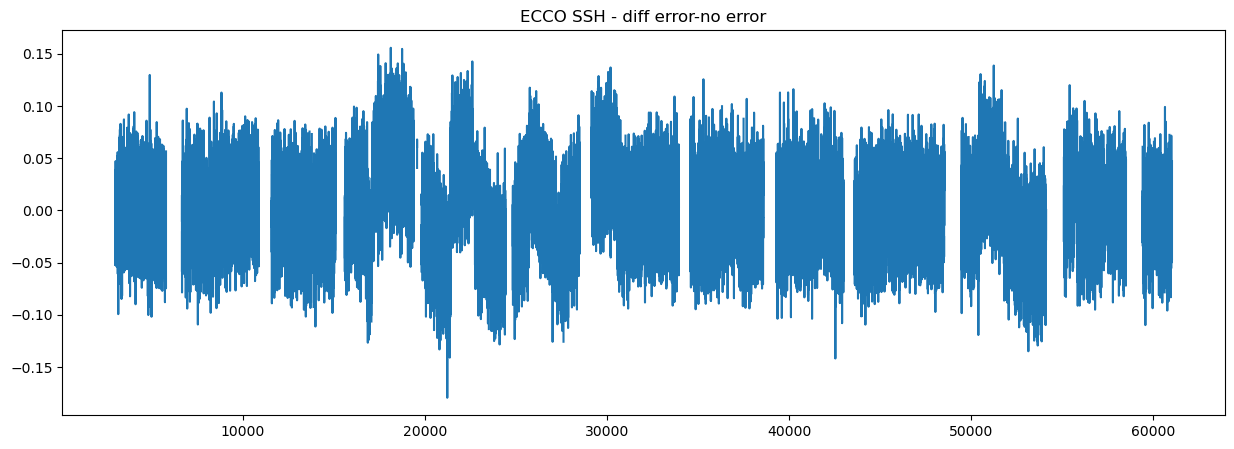

In [23]:
ECCO_at_xy = tmp[2].SSH_at_xy
fig = plt.figure(figsize=(15,5))
plt.plot(ECCO_at_xy)
plt.title('ECCO SSH')

ECCO_at_xy = tmp2[2].SSH_at_xy
fig = plt.figure(figsize=(15,5))
plt.plot(ECCO_at_xy)
plt.title('ECCO SSH - no error')

ECCO_at_xy = tmp[2].SSH_at_xy-tmp2[2].SSH_at_xy
fig = plt.figure(figsize=(15,5))
plt.plot(ECCO_at_xy)
plt.title('ECCO SSH - diff error-no error')